In [2]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.2 MB/s eta 0:00:00 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing necessary libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup
import json

In [6]:
# Function definitions

def find_headline_by_keyword(url, start_marker, end_marker, output_csv='extracted_newsHeadlines.csv'):
    """
    Extracts 'content_elements' from Fusion.globalContent found in a webpage and saves them into a CSV file.

    Parameters:
    - url (str): The URL of the webpage to scrape.
    - output_csv (str, optional): The filename for the output CSV (default is 'extracted_newsHeadlines.csv').

    Returns:
    - pd.DataFrame: Extracted data in DataFrame format.
    """
    try:
        # Fetch the webpage content
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the script tag with id="fusion-metadata"
        script_tag = soup.find('script', id='fusion-metadata')

        if script_tag:
            # Extract the content inside the script tag
            script_content = script_tag.string

            if script_content:
                # Find the start and end markers for Fusion.globalContent
                start_index = script_content.find(start_marker)
                end_index = script_content.find(end_marker, start_index)

                if start_index != -1 and end_index != -1:
                    # Move past the start marker and include the end marker
                    start_index += len(start_marker)
                    end_index += 1

                    # Extract the JSON data
                    json_content = script_content[start_index:end_index].strip()

                    # Check if the extracted content ends with a valid JSON object
                    if json_content.endswith('}'):
                        # Load the json data
                        global_content = json.loads(json_content)

                        # Check if 'content_elements' exists in global_content
                        if 'content_elements' in global_content:
                            content_elements = global_content['content_elements']

                            # Extracting specific fields into a list of dictionaries
                            extracted_data = []
                            for element in content_elements:
                                extracted_data.append({
                                    'display_date': element.get('display_date', None),
                                    'headlines': element.get('headlines', None)['basic'],
                                    'description': element.get('description', None)['basic']
                                })

                            # Convert extracted_data into a DataFrame
                            extracted_df = pd.DataFrame(extracted_data)

                            # Output the DataFrame to a CSV file
                            extracted_df.to_csv(output_csv, index=False)
                            print(f"Extracted data saved to {output_csv}")
                        else:
                            print("No 'content_elements' found in Fusion.globalContent.")
                    else:
                        print("JSON content is incomplete or malformed.")
                else:
                    print("Start or end markers not found in script content.")
            else:
                print("Script tag content is empty.")
        else:
            print("Script tag with id 'fusion-metadata' not found.")

    except requests.RequestException as e:
        print(f"Error fetching URL: {e}")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")

    return extracted_df

In [3]:
def get_sentiment_score(text):
    """
    Computes the sentiment score of a text using VADER sentiment analysis.

    Parameters:
    - text (str): The input text for sentiment analysis.

    Returns:
    - float: The sentiment score of the input text.
    """
    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Analyze sentiment
    sentiment = analyzer.polarity_scores(text)

    # Return compound score, which is a normalized sentiment score
    return sentiment['compound']

In [4]:
def plot_sentiment_over_time(dataframe, sentiment_score_col='sentiment_score'):
    """
    Plot average sentiment score over time from a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing 'date' (datetime), 'sentiment_score' (float), and 'headlines' (str) columns.
    - sentiment_score_col (str, optional): Name of the column containing sentiment scores (default is 'sentiment_score').

    Returns:
    - str: Headline corresponding to the lowest sentiment score.
    """
    # Convert 'date' column to datetime if it's not already
    dataframe['date'] = pd.to_datetime(dataframe['display_date'])

    # Group by 'date' and calculate mean sentiment score
    avg_sentiment_by_date = dataframe.groupby('date')[sentiment_score_col].mean()

    # Plotting the time-series
    plt.figure(figsize=(10, 6))
    plt.plot(avg_sentiment_by_date.index, avg_sentiment_by_date.values, marker='o', linestyle='-', color='b', label='Average Sentiment Score')

    # Add trend line
    z = np.polyfit(range(len(avg_sentiment_by_date)), avg_sentiment_by_date.values, 1)
    p = np.poly1d(z)
    plt.plot(avg_sentiment_by_date.index, p(range(len(avg_sentiment_by_date))), "r--", label='Trend Line')

    # Label the lowest point
    lowest_idx = np.argmin(avg_sentiment_by_date.values)
    lowest_score = avg_sentiment_by_date.values[lowest_idx]
    lowest_date = avg_sentiment_by_date.index[lowest_idx]
    lowest_headline = dataframe.loc[dataframe[sentiment_score_col].idxmin(), 'headlines']

    plt.annotate(f'Lowest Point: {lowest_headline}', xy=(lowest_date, lowest_score),
                 xytext=(lowest_date, lowest_score - 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    plt.title('Average Sentiment Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return lowest_headline

Extracted data saved to extracted_newsHeadlines.csv


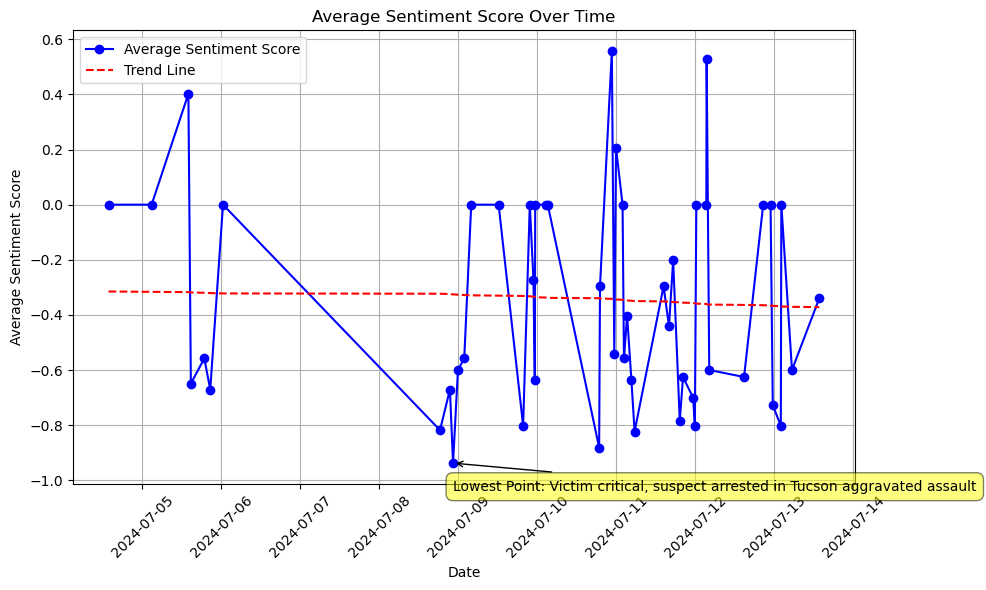

'Victim critical, suspect arrested in Tucson aggravated assault'

In [7]:
# Main execution script

# 1. Scrape the headlines, a few lines, and date of posts of 'Crime news in New York’ (or a place of your choice) spanning a few weeks from a news website.
url = 'https://www.kold.com/news/crime/'
start_marker = 'Fusion.globalContent='
end_marker = '};'

# Assuming find_headline_by_keyword returns a DataFrame with 'headlines' column
extracted_df = find_headline_by_keyword(url, start_marker, end_marker)

# 2. Use an open-source sentiment analysis tool to score the sentiments of the headlines
# Applying sentiment analysis and adding a 'sentiment_score_headlines' column
extracted_df['sentiment_score_headlines'] = extracted_df['headlines'].apply(get_sentiment_score)

# 3. Create a time-series plot of average sentiment score against date
# Apply plot_sentiment_over_time
plot_sentiment_over_time(extracted_df, sentiment_score_col='sentiment_score_headlines')

# Find and present to a non-technical person the most relevant topics relating to Crime in the period.

Observation from Sentiment Analysis Results

	1.	Overall Negative Trend: Predictively, the sentiment analysis shows a predominantly negative trend over the period, indicating that crime news generally had a negative impact.
	2.	Variable Sentiment: There are significant fluctuations in sentiment scores, with both positive and negative spikes, reflecting the diverse nature of the news reported.
	3.	Slight Downward Trend: The overall trend line indicates a slight downward movement, suggesting a gradual increase in negative sentiment over time in last week
